In [1]:
import numpy as np
from fpcross import ij, Grid, Func, Solver, Model, Check

ij()

Start | 12:05PM MSK on Nov 27, 2019 | python 3.7.1    |
-------------------------------------------------------


Let solve
$$
    \frac{\partial \psi}{\partial t}
    =
    - A \psi,
    \quad
    \psi(0) = \psi_0,
    \quad
    x \in \Omega,
$$
where
$$
    A \psi
    =
    - \epsilon \Delta \psi
    + div({\psi v}),
$$
with $\epsilon \in R$ and $v \in R^{d}$.

We have
$$
    \frac{\partial \psi}{\partial t}
    = \epsilon \Delta \psi - div({\psi v}).
$$

Note that for the case of potential field $v = grad(\phi)$ the analytical solution of the stationary problem is given as $\psi = C e^{-\frac{\phi}{\epsilon}}$, where the constant $C$ is defined to satisfy the normalization condition $\int_{\Omega} \psi \, d x = 1$.

Consider three-dimensional equation (dumbbell model)
$$
    \epsilon=\frac{1}{2},
    \quad
    v = K x - \frac{1}{2} grad(\phi),
    \quad
    x \in [-a, a]^3,
$$
where
$$
    \phi = \frac{1}{2} |x|^2 + \frac{\alpha}{p^3} e^{-\frac{|x|^2}{2 p^2}},
$$
and
$$
    K = \beta \begin{bmatrix}
        0 & 1 & 0 \\
        0 & 0 & 0 \\
        0 & 0 & 0
    \end{bmatrix}.
$$

We have
$$
    v
    =
    [v_1, v_2, v_3]^T =
    K x
    - \frac{1}{2} x
    + \frac{\alpha}{2 p^5} e^{-\frac{|x|^2}{2 p^2}} x,
$$

$$
    \frac{\partial v_1}{\partial x_1}
    =
    - \frac{1}{2}
    + \frac{\alpha}{2 p^5} e^{-\frac{|x|^2}{2 p^2}}
    - \frac{\alpha}{2 p^7} e^{-\frac{|x|^2}{2 p^2}} x_1^2,
$$

$$
    \frac{\partial v_2}{\partial x_2}
    =
    - \frac{1}{2}
    + \frac{\alpha}{2 p^5} e^{-\frac{|x|^2}{2 p^2}}
    - \frac{\alpha}{2 p^7} e^{-\frac{|x|^2}{2 p^2}} x_2^2,
$$

$$
    \frac{\partial v_3}{\partial x_3}
    =
    - \frac{1}{2}
    + \frac{\alpha}{2 p^5} e^{-\frac{|x|^2}{2 p^2}}
    - \frac{\alpha}{2 p^7} e^{-\frac{|x|^2}{2 p^2}} x_3^2.
$$

We select parameter values as in the paper
$$
    \beta = 1,
    \quad
    \alpha = 0.1,
    \quad
    p = 0.5,
    \quad
    x \in [-10, 10]^3,
    \quad
    t \in [0, 10],
    \quad
    \epsilon = 10^{-6}.
$$

We solve FPE and obtain solution $\rho(x)$. Using this solution we can compute the Kramer expression
$$
    \tau = \int \rho(x) \left[ x \otimes grad(\phi) \right] d x,
$$
where
$$
    grad(\phi) = x - \frac{\alpha}{p^5} e^{-\frac{x^2}{2 p^2}} x.
$$

Then we can compute the following scalar values
$$
    \eta = - \frac{\tau_{12}}{\beta},
    \quad
    \Psi = - \frac{\tau_{11} - \tau_{22}}{\beta^2}.
$$

It is expected from the paper
$$
    \eta = 1.0328125,
    \quad
    \Psi = 2.071143.
$$

In [2]:
a = 0.1
b = 1.
p = 0.5
s = 1.
D = 0.5

def dphi(X):
    ''' Grad \phi.'''
    return X - a / 2. / p**5 * np.exp(-np.sum(X*X, axis=0) / 2. / p**2) * X

def deta(X, r):
    p = dphi(X)
    return 1. * r * X[0, :] * p[1, :]  / b

def dpsi(X, r):
    p = dphi(X)
    return 1. * r * (X[0, :] * p[0, :] - X[1, :] * p[1, :]) / b**2

class Model_(Model):

    def d(self):
        return 3
    
    def D(self):
        return D

    def f0(self, X, t):
        mult = a / 2. / p**5 * np.exp(-np.sum(X*X, axis=0) / 2. / p**2)
        return np.vstack([
            -0.5 * X[0, :] + mult * X[0, :] + b * X[1, :],
            -0.5 * X[1, :] + mult * X[1, :],
            -0.5 * X[2, :] + mult * X[2, :]
        ])

    def f1(self, X, t):
        mult = a / 2. / p**5 * np.exp(-np.sum(X*X, axis=0) / 2. / p**2)  
        return np.vstack([
            -0.5 + mult - mult / p**2 * X[0, :]**2,
            -0.5 + mult - mult / p**2 * X[1, :]**2,
            -0.5 + mult - mult / p**2 * X[2, :]**2
        ])

    def r0(self, X):
        a = 2. * s
        r = np.exp(-np.sum(X*X, axis=0) / a) / (np.pi * a)**1.5
        return r.reshape(-1)

In [3]:
def func(SL):
    FN0 = SL.FN.copy().calc()
    
    FN = Func(SL.SG, eps=1.E-6, with_tt=True)
    FN.init(lambda X: deta(X, FN0.comp(X))).prep().calc()
    uc = FN.comp_int()
    ur = +1.0328125
    e = np.abs(ur - uc) / np.abs(ur)
    e_list.append(uc)
    # print('Eta | Calc  : %-8.2e | Real  : %-8.2e | Err : %-8.2e'%(uc, ur, e))
          
    FN = Func(SL.SG, eps=1.E-6, with_tt=True)
    FN.init(lambda X: dpsi(X, FN0.comp(X))).prep().calc()
    uc = FN.comp_int()
    ur = +2.071143
    e = np.abs(ur - uc) / np.abs(ur)
    p_list.append(uc)  
    # print('Psi | Calc  : %-8.2e | Real  : %-8.2e | Err : %-8.2e'%(uc, ur, e))

    t_list.append(SL.t)

In [4]:
t_list = []
e_list = []
p_list = []

In [5]:
SL = Solver(
    TG=Grid(d=1, n=100, l=[+ 0., +10.], k='u'),
    SG=Grid(d=3, n= 20, l=[-10., +10.], k='c'),
    MD=Model_(), eps=1.E-3, with_tt=True
).init({
    'n_hst': 10,
    'f_post': func,
    'with_rhs': False,
}).prep().calc()

SL.info()

Solve: 100%|█| 99/99 [08:00<00:00,  4.58s/step, | At T=1.0e+01 :                                                                                                       Edert=6.5e-04 r=4.48e+00]

------------------ Solver
Format    : 3D, TT, eps= 1.00e-03 [order=2]
Hst pois  : 10 
Hst with r: No 
d r / d t : 6.54e-04
Time full : 4.80e+02 
Time prep : 8.81e-03 
Time calc : 4.80e+02 
    .init : 2.52e-02 
    .prep : 3.20e-04 
    .diff : 1.89e-01 
    .conv : 2.86e+01 
    .post : 4.51e+02 
    .last : 3.36e-03 



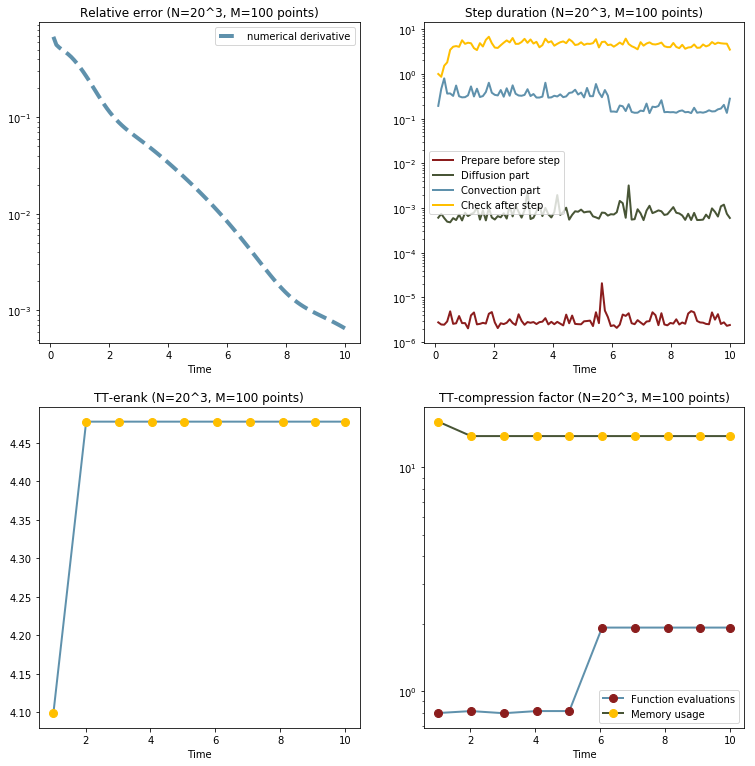

In [7]:
SL.plot()

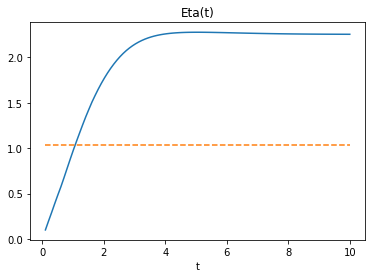

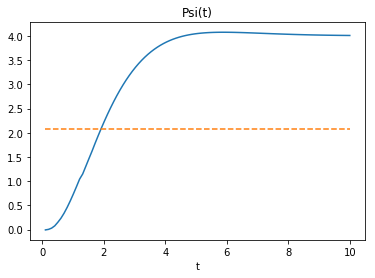

In [8]:
import matplotlib.pyplot as plt

plt.plot(t_list, e_list)
plt.plot(t_list, [1.0328125] * len(t_list), '--')
plt.title('Eta(t)')
plt.xlabel('t')
plt.show()

plt.plot(t_list, p_list)
plt.plot(t_list, [2.0711430] * len(t_list), '--')
plt.title('Psi(t)')
plt.xlabel('t')
plt.show()

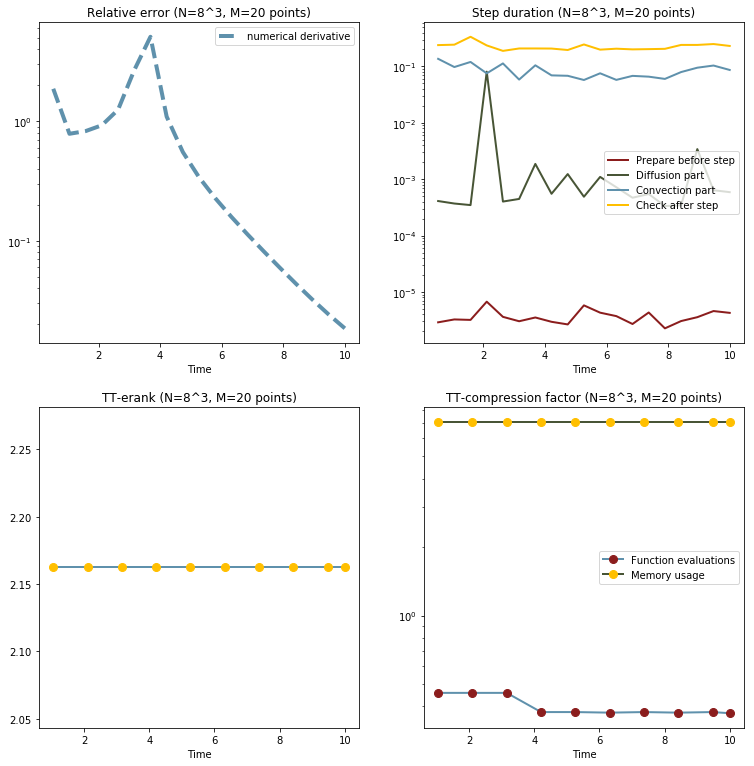

In [8]:
SL.plot()

In [8]:
SL = Solver(
    TG=Grid(d=1, n=100, l=[+ 0., +10.], k='u'),
    SG=Grid(d=3, n= 20, l=[-10., +10.], k='c'),
    MD=Model_(), eps=1.E-3, with_tt=True
).init({
    'n_hst': 0,
    'f_post': func,
    'with_rhs': False,
}).prep().calc()

SL.info()

Solve:   0%|                                           | 0/99 [00:00<?, ?step/s]

Eta | Calc  : 1.01e-01 | Real  : 1.03e+00 | Err : 9.03e-01


Solve:   1%|▎                                  | 1/99 [00:01<01:43,  1.06s/step]

Psi | Calc  : -8.36e-03 | Real  : 2.07e+00 | Err : 1.00e+00
Eta | Calc  : 1.98e-01 | Real  : 1.03e+00 | Err : 8.08e-01


Solve:   2%|▋                                  | 2/99 [00:02<01:56,  1.20s/step]

Psi | Calc  : 2.95e-03 | Real  : 2.07e+00 | Err : 9.99e-01
Eta | Calc  : 2.93e-01 | Real  : 1.03e+00 | Err : 7.17e-01


Solve:   3%|█                                  | 3/99 [00:05<02:33,  1.59s/step]

Psi | Calc  : 2.88e-02 | Real  : 2.07e+00 | Err : 9.86e-01
Eta | Calc  : 3.91e-01 | Real  : 1.03e+00 | Err : 6.22e-01


Solve:   4%|█▍                                 | 4/99 [00:06<02:35,  1.64s/step]

Psi | Calc  : 7.54e-02 | Real  : 2.07e+00 | Err : 9.64e-01
Eta | Calc  : 4.86e-01 | Real  : 1.03e+00 | Err : 5.30e-01


Solve:   5%|█▊                                 | 5/99 [00:10<03:18,  2.11s/step]

Psi | Calc  : 1.50e-01 | Real  : 2.07e+00 | Err : 9.28e-01
Eta | Calc  : 5.77e-01 | Real  : 1.03e+00 | Err : 4.41e-01


Solve:   6%|██                                 | 6/99 [00:14<04:15,  2.75s/step]

Psi | Calc  : 2.33e-01 | Real  : 2.07e+00 | Err : 8.87e-01
Eta | Calc  : 6.77e-01 | Real  : 1.03e+00 | Err : 3.44e-01


Solve:   7%|██▍                                | 7/99 [00:18<04:51,  3.17s/step]

Psi | Calc  : 3.37e-01 | Real  : 2.07e+00 | Err : 8.37e-01
Eta | Calc  : 7.80e-01 | Real  : 1.03e+00 | Err : 2.45e-01


Solve:   8%|██▊                                | 8/99 [00:23<05:50,  3.85s/step]

Psi | Calc  : 4.58e-01 | Real  : 2.07e+00 | Err : 7.79e-01
Eta | Calc  : 8.81e-01 | Real  : 1.03e+00 | Err : 1.47e-01


Solve:   9%|███▏                               | 9/99 [00:29<06:25,  4.29s/step]

Psi | Calc  : 5.91e-01 | Real  : 2.07e+00 | Err : 7.15e-01
Eta | Calc  : 9.81e-01 | Real  : 1.03e+00 | Err : 5.05e-02


Solve:  10%|███▍                              | 10/99 [00:33<06:22,  4.30s/step]

Psi | Calc  : 7.35e-01 | Real  : 2.07e+00 | Err : 6.45e-01
Eta | Calc  : 1.08e+00 | Real  : 1.03e+00 | Err : 4.16e-02


Solve:  11%|███▊                              | 11/99 [00:38<06:43,  4.59s/step]

Psi | Calc  : 8.86e-01 | Real  : 2.07e+00 | Err : 5.72e-01
Eta | Calc  : 1.17e+00 | Real  : 1.03e+00 | Err : 1.31e-01


Solve:  12%|████                              | 12/99 [00:43<06:47,  4.69s/step]

Psi | Calc  : 1.04e+00 | Real  : 2.07e+00 | Err : 4.97e-01
Eta | Calc  : 1.26e+00 | Real  : 1.03e+00 | Err : 2.19e-01


Solve:  13%|████▍                             | 13/99 [00:47<06:31,  4.55s/step]

Psi | Calc  : 1.15e+00 | Real  : 2.07e+00 | Err : 4.46e-01
Eta | Calc  : 1.35e+00 | Real  : 1.03e+00 | Err : 3.05e-01


Solve:  14%|████▊                             | 14/99 [00:53<06:46,  4.79s/step]

Psi | Calc  : 1.31e+00 | Real  : 2.07e+00 | Err : 3.70e-01
Eta | Calc  : 1.43e+00 | Real  : 1.03e+00 | Err : 3.84e-01


Solve:  15%|█████▏                            | 15/99 [00:57<06:25,  4.59s/step]

Psi | Calc  : 1.46e+00 | Real  : 2.07e+00 | Err : 2.94e-01
Eta | Calc  : 1.51e+00 | Real  : 1.03e+00 | Err : 4.62e-01


Solve:  16%|█████▍                            | 16/99 [01:01<06:06,  4.41s/step]

Psi | Calc  : 1.62e+00 | Real  : 2.07e+00 | Err : 2.18e-01
Eta | Calc  : 1.58e+00 | Real  : 1.03e+00 | Err : 5.31e-01


Solve:  17%|█████▊                            | 17/99 [01:07<06:37,  4.84s/step]

Psi | Calc  : 1.78e+00 | Real  : 2.07e+00 | Err : 1.39e-01
Eta | Calc  : 1.65e+00 | Real  : 1.03e+00 | Err : 5.98e-01


Solve:  18%|██████▏                           | 18/99 [01:12<06:41,  4.96s/step]

Psi | Calc  : 1.94e+00 | Real  : 2.07e+00 | Err : 6.28e-02
Eta | Calc  : 1.71e+00 | Real  : 1.03e+00 | Err : 6.60e-01


Solve:  19%|██████▌                           | 19/99 [01:17<06:42,  5.03s/step]

Psi | Calc  : 2.09e+00 | Real  : 2.07e+00 | Err : 1.13e-02
Eta | Calc  : 1.77e+00 | Real  : 1.03e+00 | Err : 7.18e-01


Solve:  20%|██████▊                           | 20/99 [01:21<06:19,  4.80s/step]

Psi | Calc  : 2.24e+00 | Real  : 2.07e+00 | Err : 8.25e-02
Eta | Calc  : 1.83e+00 | Real  : 1.03e+00 | Err : 7.71e-01


Solve:  21%|███████▏                          | 21/99 [01:25<05:52,  4.51s/step]

Psi | Calc  : 2.38e+00 | Real  : 2.07e+00 | Err : 1.51e-01
Eta | Calc  : 1.88e+00 | Real  : 1.03e+00 | Err : 8.20e-01


Solve:  22%|███████▌                          | 22/99 [01:30<06:01,  4.69s/step]

Psi | Calc  : 2.52e+00 | Real  : 2.07e+00 | Err : 2.16e-01
Eta | Calc  : 1.93e+00 | Real  : 1.03e+00 | Err : 8.65e-01


Solve:  23%|███████▉                          | 23/99 [01:36<06:10,  4.87s/step]

Psi | Calc  : 2.65e+00 | Real  : 2.07e+00 | Err : 2.78e-01
Eta | Calc  : 1.97e+00 | Real  : 1.03e+00 | Err : 9.07e-01


Solve:  24%|████████▏                         | 24/99 [01:41<06:18,  5.05s/step]

Psi | Calc  : 2.77e+00 | Real  : 2.07e+00 | Err : 3.37e-01
Eta | Calc  : 2.01e+00 | Real  : 1.03e+00 | Err : 9.44e-01


Solve:  25%|████████▌                         | 25/99 [01:46<06:19,  5.12s/step]

Psi | Calc  : 2.88e+00 | Real  : 2.07e+00 | Err : 3.92e-01
Eta | Calc  : 2.04e+00 | Real  : 1.03e+00 | Err : 9.78e-01


Solve:  26%|████████▉                         | 26/99 [01:52<06:19,  5.20s/step]

Psi | Calc  : 2.99e+00 | Real  : 2.07e+00 | Err : 4.44e-01
Eta | Calc  : 2.07e+00 | Real  : 1.03e+00 | Err : 1.01e+00


Solve:  27%|█████████▎                        | 27/99 [01:57<06:19,  5.28s/step]

Psi | Calc  : 3.09e+00 | Real  : 2.07e+00 | Err : 4.92e-01
Eta | Calc  : 2.10e+00 | Real  : 1.03e+00 | Err : 1.04e+00


Solve:  28%|█████████▌                        | 28/99 [02:03<06:20,  5.36s/step]

Psi | Calc  : 3.19e+00 | Real  : 2.07e+00 | Err : 5.38e-01
Eta | Calc  : 2.13e+00 | Real  : 1.03e+00 | Err : 1.06e+00


Solve:  29%|█████████▉                        | 29/99 [02:09<06:24,  5.49s/step]

Psi | Calc  : 3.27e+00 | Real  : 2.07e+00 | Err : 5.80e-01
Eta | Calc  : 2.15e+00 | Real  : 1.03e+00 | Err : 1.08e+00


Solve:  30%|██████████▎                       | 30/99 [02:16<07:07,  6.19s/step]

Psi | Calc  : 3.35e+00 | Real  : 2.07e+00 | Err : 6.19e-01
Eta | Calc  : 2.17e+00 | Real  : 1.03e+00 | Err : 1.10e+00


Solve:  31%|██████████▋                       | 31/99 [02:22<06:56,  6.12s/step]

Psi | Calc  : 3.43e+00 | Real  : 2.07e+00 | Err : 6.56e-01
Eta | Calc  : 2.19e+00 | Real  : 1.03e+00 | Err : 1.12e+00


Solve:  32%|██████████▉                       | 32/99 [02:28<06:44,  6.03s/step]

Psi | Calc  : 3.50e+00 | Real  : 2.07e+00 | Err : 6.89e-01
Eta | Calc  : 2.20e+00 | Real  : 1.03e+00 | Err : 1.13e+00


Solve:  33%|███████████▎                      | 33/99 [02:35<06:47,  6.17s/step]

Psi | Calc  : 3.56e+00 | Real  : 2.07e+00 | Err : 7.20e-01
Eta | Calc  : 2.21e+00 | Real  : 1.03e+00 | Err : 1.14e+00


Solve:  34%|███████████▋                      | 34/99 [02:43<07:31,  6.95s/step]

Psi | Calc  : 3.62e+00 | Real  : 2.07e+00 | Err : 7.48e-01
Eta | Calc  : 2.23e+00 | Real  : 1.03e+00 | Err : 1.15e+00


Solve:  35%|████████████                      | 35/99 [02:53<08:18,  7.79s/step]

Psi | Calc  : 3.67e+00 | Real  : 2.07e+00 | Err : 7.74e-01
Eta | Calc  : 2.24e+00 | Real  : 1.03e+00 | Err : 1.16e+00


Solve:  36%|████████████▎                     | 36/99 [02:59<07:31,  7.17s/step]

Psi | Calc  : 3.72e+00 | Real  : 2.07e+00 | Err : 7.98e-01
Eta | Calc  : 2.24e+00 | Real  : 1.03e+00 | Err : 1.17e+00


Solve:  37%|████████████▋                     | 37/99 [03:03<06:33,  6.34s/step]

Psi | Calc  : 3.77e+00 | Real  : 2.07e+00 | Err : 8.19e-01
Eta | Calc  : 2.25e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  38%|█████████████                     | 38/99 [03:08<06:00,  5.91s/step]

Psi | Calc  : 3.81e+00 | Real  : 2.07e+00 | Err : 8.39e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  39%|█████████████▍                    | 39/99 [03:13<05:30,  5.50s/step]

Psi | Calc  : 3.84e+00 | Real  : 2.07e+00 | Err : 8.56e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  40%|█████████████▋                    | 40/99 [03:18<05:12,  5.30s/step]

Psi | Calc  : 3.88e+00 | Real  : 2.07e+00 | Err : 8.72e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  41%|██████████████                    | 41/99 [03:23<04:59,  5.17s/step]

Psi | Calc  : 3.91e+00 | Real  : 2.07e+00 | Err : 8.86e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  42%|██████████████▍                   | 42/99 [03:27<04:40,  4.92s/step]

Psi | Calc  : 3.93e+00 | Real  : 2.07e+00 | Err : 8.98e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  43%|██████████████▊                   | 43/99 [03:32<04:32,  4.87s/step]

Psi | Calc  : 3.95e+00 | Real  : 2.07e+00 | Err : 9.09e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  44%|███████████████                   | 44/99 [03:36<04:20,  4.73s/step]

Psi | Calc  : 3.98e+00 | Real  : 2.07e+00 | Err : 9.19e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  45%|███████████████▍                  | 45/99 [03:41<04:15,  4.73s/step]

Psi | Calc  : 3.99e+00 | Real  : 2.07e+00 | Err : 9.28e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  46%|███████████████▊                  | 46/99 [03:45<04:07,  4.67s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.35e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  47%|████████████████▏                 | 47/99 [03:50<03:57,  4.58s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.42e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.21e+00


Solve:  48%|████████████████▍                 | 48/99 [03:55<04:00,  4.71s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.48e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.21e+00


Solve:  49%|████████████████▊                 | 49/99 [03:59<03:52,  4.65s/step]

Psi | Calc  : 4.04e+00 | Real  : 2.07e+00 | Err : 9.52e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.21e+00


Solve:  51%|█████████████████▏                | 50/99 [04:04<03:45,  4.61s/step]

Psi | Calc  : 4.05e+00 | Real  : 2.07e+00 | Err : 9.56e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.21e+00


Solve:  52%|█████████████████▌                | 51/99 [04:09<03:47,  4.73s/step]

Psi | Calc  : 4.06e+00 | Real  : 2.07e+00 | Err : 9.60e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.21e+00


Solve:  53%|█████████████████▊                | 52/99 [04:14<03:43,  4.76s/step]

Psi | Calc  : 4.06e+00 | Real  : 2.07e+00 | Err : 9.62e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  54%|██████████████████▏               | 53/99 [04:17<03:24,  4.44s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.65e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  55%|██████████████████▌               | 54/99 [04:22<03:25,  4.56s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.66e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  56%|██████████████████▉               | 55/99 [04:27<03:20,  4.56s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.67e-01
Eta | Calc  : 2.28e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  57%|███████████████████▏              | 56/99 [04:32<03:21,  4.68s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.68e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  58%|███████████████████▌              | 57/99 [04:36<03:07,  4.45s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.69e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  59%|███████████████████▉              | 58/99 [04:40<03:00,  4.40s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.69e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  60%|████████████████████▎             | 59/99 [04:44<02:52,  4.30s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.69e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  61%|████████████████████▌             | 60/99 [04:48<02:46,  4.27s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.69e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  62%|████████████████████▉             | 61/99 [04:53<02:50,  4.48s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.68e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  63%|█████████████████████▎            | 62/99 [04:58<02:46,  4.49s/step]

Psi | Calc  : 4.08e+00 | Real  : 2.07e+00 | Err : 9.68e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  64%|█████████████████████▋            | 63/99 [05:01<02:32,  4.24s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.67e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  65%|█████████████████████▉            | 64/99 [05:05<02:24,  4.14s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.66e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  66%|██████████████████████▎           | 65/99 [05:09<02:19,  4.10s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.65e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.20e+00


Solve:  67%|██████████████████████▋           | 66/99 [05:13<02:11,  4.00s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.64e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  68%|███████████████████████           | 67/99 [05:17<02:13,  4.16s/step]

Psi | Calc  : 4.07e+00 | Real  : 2.07e+00 | Err : 9.63e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  69%|███████████████████████▎          | 68/99 [05:21<02:07,  4.11s/step]

Psi | Calc  : 4.06e+00 | Real  : 2.07e+00 | Err : 9.62e-01
Eta | Calc  : 2.27e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  70%|███████████████████████▋          | 69/99 [05:25<01:58,  3.95s/step]

Psi | Calc  : 4.06e+00 | Real  : 2.07e+00 | Err : 9.60e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  71%|████████████████████████          | 70/99 [05:29<01:52,  3.89s/step]

Psi | Calc  : 4.06e+00 | Real  : 2.07e+00 | Err : 9.59e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  72%|████████████████████████▍         | 71/99 [05:34<01:57,  4.20s/step]

Psi | Calc  : 4.06e+00 | Real  : 2.07e+00 | Err : 9.58e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  73%|████████████████████████▋         | 72/99 [05:38<01:55,  4.27s/step]

Psi | Calc  : 4.05e+00 | Real  : 2.07e+00 | Err : 9.57e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  74%|█████████████████████████         | 73/99 [05:43<01:56,  4.50s/step]

Psi | Calc  : 4.05e+00 | Real  : 2.07e+00 | Err : 9.56e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  75%|█████████████████████████▍        | 74/99 [05:47<01:51,  4.45s/step]

Psi | Calc  : 4.05e+00 | Real  : 2.07e+00 | Err : 9.54e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  76%|█████████████████████████▊        | 75/99 [05:52<01:45,  4.41s/step]

Psi | Calc  : 4.05e+00 | Real  : 2.07e+00 | Err : 9.53e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  77%|██████████████████████████        | 76/99 [05:56<01:42,  4.46s/step]

Psi | Calc  : 4.04e+00 | Real  : 2.07e+00 | Err : 9.52e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  78%|██████████████████████████▍       | 77/99 [06:01<01:38,  4.47s/step]

Psi | Calc  : 4.04e+00 | Real  : 2.07e+00 | Err : 9.51e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  79%|██████████████████████████▊       | 78/99 [06:05<01:31,  4.37s/step]

Psi | Calc  : 4.04e+00 | Real  : 2.07e+00 | Err : 9.50e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  80%|███████████████████████████▏      | 79/99 [06:10<01:28,  4.45s/step]

Psi | Calc  : 4.04e+00 | Real  : 2.07e+00 | Err : 9.49e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  81%|███████████████████████████▍      | 80/99 [06:14<01:22,  4.37s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.48e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  82%|███████████████████████████▊      | 81/99 [06:19<01:20,  4.50s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.47e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  83%|████████████████████████████▏     | 82/99 [06:23<01:15,  4.43s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.46e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  84%|████████████████████████████▌     | 83/99 [06:27<01:09,  4.32s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.45e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  85%|████████████████████████████▊     | 84/99 [06:31<01:01,  4.12s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.44e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  86%|█████████████████████████████▏    | 85/99 [06:35<01:00,  4.30s/step]

Psi | Calc  : 4.03e+00 | Real  : 2.07e+00 | Err : 9.44e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  87%|█████████████████████████████▌    | 86/99 [06:39<00:54,  4.23s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.43e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  88%|█████████████████████████████▉    | 87/99 [06:44<00:52,  4.40s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.42e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  89%|██████████████████████████████▏   | 88/99 [06:48<00:48,  4.36s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.42e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.19e+00


Solve:  90%|██████████████████████████████▌   | 89/99 [06:53<00:43,  4.32s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.41e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  91%|██████████████████████████████▉   | 90/99 [06:57<00:38,  4.29s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.40e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  92%|███████████████████████████████▎  | 91/99 [07:01<00:34,  4.30s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.40e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  93%|███████████████████████████████▌  | 92/99 [07:05<00:29,  4.28s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.39e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  94%|███████████████████████████████▉  | 93/99 [07:10<00:25,  4.27s/step]

Psi | Calc  : 4.02e+00 | Real  : 2.07e+00 | Err : 9.39e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  95%|████████████████████████████████▎ | 94/99 [07:14<00:21,  4.25s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.38e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  96%|████████████████████████████████▋ | 95/99 [07:18<00:16,  4.20s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.38e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  97%|████████████████████████████████▉ | 96/99 [07:23<00:13,  4.49s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.38e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  98%|█████████████████████████████████▎| 97/99 [07:27<00:08,  4.38s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.37e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve:  99%|█████████████████████████████████▋| 98/99 [07:33<00:04,  4.67s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.37e-01
Eta | Calc  : 2.26e+00 | Real  : 1.03e+00 | Err : 1.18e+00


Solve: 100%|██████████████████████████████████| 99/99 [07:38<00:00,  4.82s/step]

Psi | Calc  : 4.01e+00 | Real  : 2.07e+00 | Err : 9.37e-01
------------------ Solver
Format    : 3D, TT, eps= 1.00e-03 [order=2]
Hst pois  : None 
Hst with r: No 
Time full : 4.58e+02 
Time prep : 2.51e-03 
Time calc : 4.58e+02 
    .init : 1.96e-02 
    .prep : 4.06e-04 
    .diff : 1.36e-01 
    .conv : 2.74e+01 
    .post : 4.31e+02 
    .last : 2.94e-03 



In [17]:
p_list[-1] / e_list[-1]

1.7784991082803832

In [18]:
2.0711430 / 1.0328125

2.0053426928895615

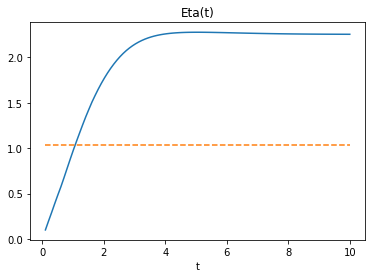

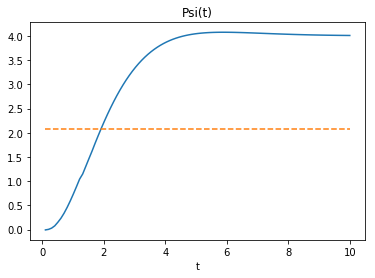

In [16]:
import matplotlib.pyplot as plt

plt.plot(t_list, e_list)
plt.plot(t_list, [1.0328125] * len(t_list), '--')
plt.title('Eta(t)')
plt.xlabel('t')
plt.show()

plt.plot(t_list, p_list)
plt.plot(t_list, [2.0711430] * len(t_list), '--')
plt.title('Psi(t)')
plt.xlabel('t')
plt.show()

In [3]:
SL = Solver(
    TG=Grid(d=1, n=100, l=[+ 0., +10.], k='u'),
    SG=Grid(d=3, n= 31, l=[-10., +10.], k='c'),
    MD=Model_(),
    eps=1.E-2, with_tt=True
).init({ 'with_rhs': True }).prep().calc()

SL.info()

Solve: 100%|█| 99/99 [01:23<00:00,  1.94step/s, | At T=1.0e+01 :                                                                                                       Edert=9.3e-05  Erhsn=3.4e+00 r=3.58e+00]

------------------ Solver
Format    : 3D, TT, eps= 1.00e-02 [order=2]
Format    : 3D, Hst pois  : 10 
Hst r     : No 
d r / d t : 9.32e-05
Err  rhs  : 3.41e+00
Time prep : 9.49e-03 
Time calc : 8.32e+01 
    .init : 2.90e-02 
    .diff : 3.54e-01 
    .conv : 8.11e+01 
    .post : 1.58e+00 
    .last : 4.53e-03 


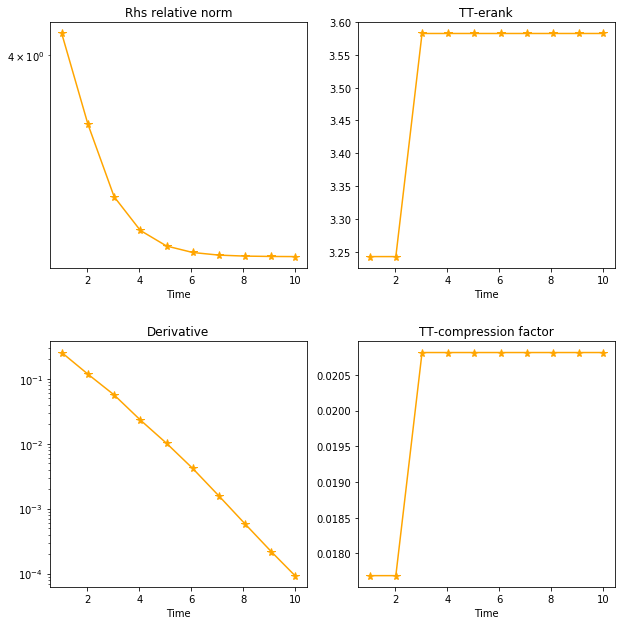

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from fpcross import config

T = SL.hst['T']

fig = plt.figure(figsize=(8, 8))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.2, hspace=0.3, width_ratios=[1, 1], height_ratios=[1, 1]
)
opts = { 'color': 'orange', 'marker': '*', 'markersize': 8, 'markeredgecolor': 'orange' }
 
ax = fig.add_subplot(gs[0, 0]) 
ax.set_title('Rhs relative norm')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['E_rhsn'], **opts)
ax.semilogy()

ax = fig.add_subplot(gs[1, 0]) 
ax.set_title('Derivative')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['E_dert'], **opts)
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.set_title('TT-erank')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['Rank_E'], **opts)

ax = fig.add_subplot(gs[1, 1])
ax.set_title('TT-compression factor')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['C_size'], **opts)

plt.show()

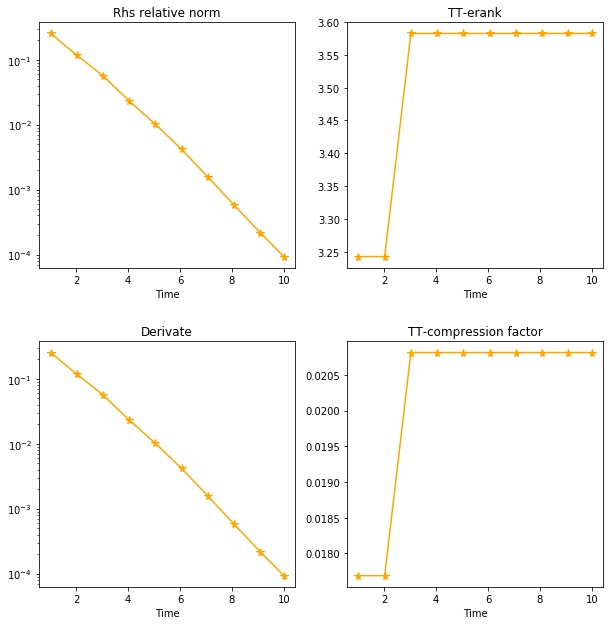

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from fpcross import config

T = SL.hst['T']

fig = plt.figure(figsize=(8, 8))
gs = mpl.gridspec.GridSpec(
    ncols=2, nrows=2, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.2, hspace=0.3, width_ratios=[1, 1], height_ratios=[1, 1]
)
opts = { 'color': 'orange', 'marker': '*', 'markersize': 8, 'markeredgecolor': 'orange' }
 
ax = fig.add_subplot(gs[0, 0]) 
ax.set_title('Rhs relative norm')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['E_dert'], **opts)
ax.semilogy()

ax = fig.add_subplot(gs[1, 0]) 
ax.set_title('Derivate')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['E_dert'], **opts)
ax.semilogy()

ax = fig.add_subplot(gs[0, 1])
ax.set_title('TT-erank')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['Rank_E'], **opts)

ax = fig.add_subplot(gs[1, 1])
ax.set_title('TT-compression factor')
ax.set_xlabel('Time')
ax.plot(T, SL.hst['C_size'], **opts)

plt.show()

In [5]:
SL = Solver(
    TG=Grid(d=1, n=10, l=[+ 0., +10.], kind='u'),
    SG=Grid(d=3, n=21, l=[-10., +10.], kind='c'),
    MD=Model_(),
).init().prep().calc()
SL.info()

Solve: 100%|█| 9/9 [01:50<00:00, 11.91s/step, | At T=1.0e+01 :                                                                                                       Int=-9.7e+03  Erhs=8.5e-01]

------------------ Solver
Format    : 3D, NP [order=2]
Format    : 3D, Hst pois  : 10 
Hst r     : No 
Norm int  : No 
Err  rhs  : 8.46e-01
Time prep : 1.84e+00 
Time calc : 1.10e+02 
...  init : 2.74e-03 
...  diff : 9.34e-01 
...  conv : 8.20e-01 
...  post : 1.08e+02 
...  last : 4.80e-03 
